<a href="https://www.kaggle.com/code/mahmoudabuelfadl/retail?scriptVersionId=239747413" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#✅ Step 1: Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Datasets
customers = pd.read_csv("/kaggle/input/retail-case-study-data/Customer.csv")
prod_cat_info = pd.read_csv("/kaggle/input/retail-case-study-data/Transactions.csv")
transactions = pd.read_csv("/kaggle/input/retail-case-study-data/prod_cat_info.csv")

In [3]:
# Check shapes
print("Customers:", customers.shape)
print("Product Categories:", prod_cat_info.shape)
print("Transactions:", transactions.shape)


Customers: (5647, 4)
Product Categories: (23053, 10)
Transactions: (23, 4)


In [4]:
# Preview data
customers.head()


,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0
3,270181,10-01-1970,F,2.0
4,268073,11-01-1970,M,1.0


In [5]:
prod_cat_info.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [6]:
transactions.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


In [7]:
# Info & nulls
customers.info()
prod_cat_info.info()
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_Id  5647 non-null   int64  
 1   DOB          5647 non-null   object 
 2   Gender       5645 non-null   object 
 3   city_code    5645 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 176.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23053 entries, 0 to 23052
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    23053 non-null  int64  
 1   cust_id           23053 non-null  int64  
 2   tran_date         23053 non-null  object 
 3   prod_subcat_code  23053 non-null  int64  
 4   prod_cat_code     23053 non-null  int64  
 5   Qty               23053 non-null  int64  
 6   Rate              23053 non-null  int64  
 7   Tax               23053 non-null  float64

In [8]:


print("Missing Values:\n")
print("Customers:\n", customers.isnull().sum())
print("Products:\n", prod_cat_info.isnull().sum())
print("Transactions:\n", transactions.isnull().sum())

Missing Values:

Customers:
 customer_Id    0
DOB            0
Gender         2
city_code      2
dtype: int64
Products:
 transaction_id      0
cust_id             0
tran_date           0
prod_subcat_code    0
prod_cat_code       0
Qty                 0
Rate                0
Tax                 0
total_amt           0
Store_type          0
dtype: int64
Transactions:
 prod_cat_code        0
prod_cat             0
prod_sub_cat_code    0
prod_subcat          0
dtype: int64


**Merge Datasets for Unified View**

In [9]:
# Merge Transactions with Product Info
df = pd.merge(transactions, prod_cat_info, on=['prod_cat_code', 'prod_cat_code'], how='left')

# Merge with Customer Info
df = pd.merge(df, customers, left_on='cust_id', right_on='customer_Id', how='left')

# Drop redundant columns
df.drop(['customer_Id'], axis=1, inplace=True)

# Final structure
print("Combined Dataset Shape:", df.shape)
df.head()

Combined Dataset Shape: (99293, 16)


,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat,transaction_id,cust_id,tran_date,prod_subcat_code,Qty,Rate,Tax,total_amt,Store_type,DOB,Gender,city_code
0,1,Clothing,4,Mens,80712190438,270351,28-02-2014,1,-5,-772,405.300,-4265.300,e-Shop,26-09-1981,M,5.0
1,1,Clothing,4,Mens,79792372943,275108,22-02-2014,3,-3,-908,286.020,-3010.020,MBR,04-11-1971,F,8.0
2,1,Clothing,4,Mens,44783317894,269452,20-02-2014,3,3,825,259.875,2734.875,TeleShop,18-09-1979,F,2.0
3,1,Clothing,4,Mens,80712190438,270351,20-02-2014,1,5,772,405.300,4265.300,e-Shop,26-09-1981,M,5.0
4,1,Clothing,4,Mens,28396777609,269101,19-02-2014,4,4,1386,582.120,6126.120,TeleShop,27-06-1980,M,7.0


In [10]:
# Convert date fields
df['tran_date'] = pd.to_datetime(df['tran_date'], dayfirst=True, errors='coerce')
df['DOB'] = pd.to_datetime(df['DOB'], dayfirst=True, errors='coerce')

# Calculate Age
df['Age'] = df['tran_date'].dt.year - df['DOB'].dt.year

# Date Features
df['Month'] = df['tran_date'].dt.month
df['Weekday'] = df['tran_date'].dt.day_name()
df['Is_Weekend'] = df['Weekday'].isin(['Saturday', 'Sunday']).astype(int)
df.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat,transaction_id,cust_id,tran_date,prod_subcat_code,Qty,Rate,Tax,total_amt,Store_type,DOB,Gender,city_code,Age,Month,Weekday,Is_Weekend
0,1,Clothing,4,Mens,80712190438,270351,2014-02-28,1,-5,-772,405.300,-4265.300,e-Shop,1981-09-26,M,5.0,33.0,2.0,Friday,0
1,1,Clothing,4,Mens,79792372943,275108,2014-02-22,3,-3,-908,286.020,-3010.020,MBR,1971-11-04,F,8.0,43.0,2.0,Saturday,1
2,1,Clothing,4,Mens,44783317894,269452,2014-02-20,3,3,825,259.875,2734.875,TeleShop,1979-09-18,F,2.0,35.0,2.0,Thursday,0
3,1,Clothing,4,Mens,80712190438,270351,2014-02-20,1,5,772,405.300,4265.300,e-Shop,1981-09-26,M,5.0,33.0,2.0,Thursday,0
4,1,Clothing,4,Mens,28396777609,269101,2014-02-19,4,4,1386,582.120,6126.120,TeleShop,1980-06-27,M,7.0,34.0,2.0,Wednesday,0


In [11]:
df.describe()


,prod_cat_code,prod_sub_cat_code,transaction_id,cust_id,tran_date,prod_subcat_code,Qty,Rate,Tax,total_amt,DOB,city_code,Age,Month,Is_Weekend
count,99293.000000,99293.000000,9.929300e+04,99293.000000,59869,99293.000000,99293.000000,99293.000000,99293.000000,99293.000000,99293,99257.000000,59869.000000,59869.000000,99293.000000
mean,4.003243,6.806985,5.007320e+10,271030.010635,2012-08-06 18:57:06.400975360,6.796894,2.438017,637.919884,248.873736,2114.616420,1981-07-16 10:22:40.845175360,5.467221,30.986320,6.492492,0.172671
min,1.000000,1.000000,3.268991e+06,266783.000000,2011-01-25 00:00:00,1.000000,-5.000000,-1499.000000,7.350000,-8270.925000,1970-01-02 00:00:00,1.000000,19.000000,1.000000,0.000000
25%,3.000000,4.000000,2.492150e+10,268956.000000,2011-10-28 00:00:00,4.000000,1.000000,313.000000,98.280000,762.450000,1975-10-02 00:00:00,3.000000,25.000000,3.000000,0.000000
50%,5.000000,7.000000,5.011083e+10,270982.000000,2012-07-31 00:00:00,7.000000,3.000000,713.000000,199.920000,1761.370000,1981-06-23 00:00:00,5.000000,31.000000,7.000000,0.000000
75%,5.000000,10.000000,7.528121e+10,273120.000000,2013-05-18 00:00:00,10.000000,4.000000,1109.000000,366.975000,3585.725000,1987-06-02 00:00:00,8.000000,37.000000,10.000000,0.000000
max,6.000000,12.000000,9.998755e+10,275265.000000,2014-02-28 00:00:00,12.000000,5.000000,1500.000000,787.500000,8287.500000,1992-12-29 00:00:00,10.000000,44.000000,12.000000,1.000000
std,1.563991,3.615952,2.899361e+10,2429.333624,NaN,3.609439,2.260726,621.576326,187.014422,2502.306768,NaN,2.859343,6.696326,3.490540,0.377964


### Data Cleaning & Preparation

In [12]:
# Check again for missing values
missing = df.isnull().sum()
print("Missing Values:\n", missing[missing > 0])

Missing Values:
 tran_date    39424
Gender          40
city_code       36
Age          39424
Month        39424
Weekday      39424
dtype: int64


In [13]:
# Drop rows with missing DOB (we need Age)
df = df[~df['DOB'].isnull()]

# Fill missing product names with 'Unknown'
df['prod_cat'] = df['prod_cat'].fillna('Unknown')
df['prod_subcat'] = df['prod_subcat'].fillna('Unknown')

In [14]:
# Remove exact duplicate rows
df = df.drop_duplicates()

## Write comment ... 

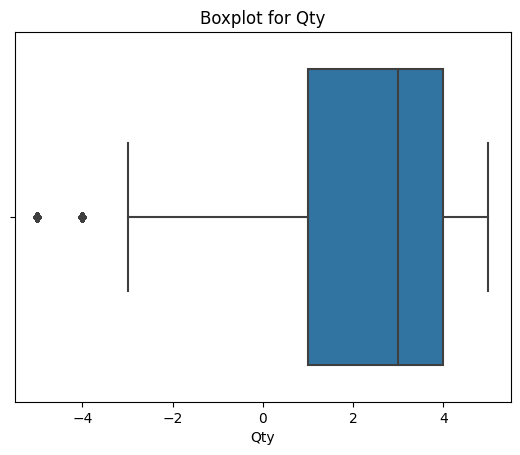

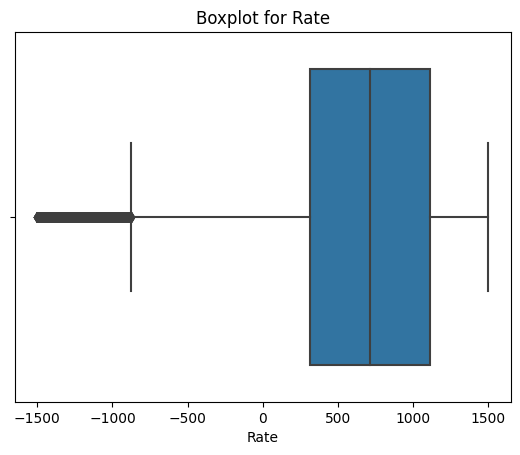

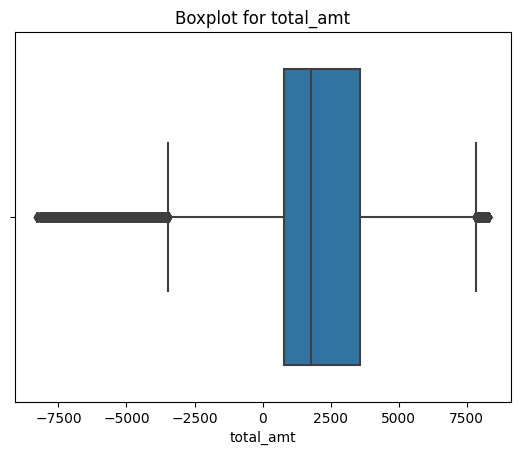

In [15]:
# Box plot to detect outliers
for col in ['Qty', 'Rate', 'total_amt']:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

In [16]:
# Capping outliers with IQR method Instead of removing them.
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

df['Qty'] = cap_outliers(df['Qty'])
df['Rate'] = cap_outliers(df['Rate'])
df['total_amt'] = cap_outliers(df['total_amt'])

In [17]:
#  Feature Scaling

scaler = StandardScaler()
num_cols = ['Qty', 'Rate', 'Tax', 'total_amt']

df[num_cols] = scaler.fit_transform(df[num_cols])

In [44]:
# Label encode gender
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # M=1, F=2

# One-hot encode product category and store type (for ML models)
df_encoded = pd.get_dummies(df, columns=['Store_type', 'prod_cat'], drop_first=True)

## Train-Test Split

In [45]:

# Example target: total_amt (for regression)
X = df_encoded.drop(['total_amt', 'tran_date', 'DOB', 'prod_subcat', 'Weekday'], axis=1)
y = df_encoded['total_amt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## The dataset is now clean, encoded, scaled, and ready for modeling.

## Univariate Analysis

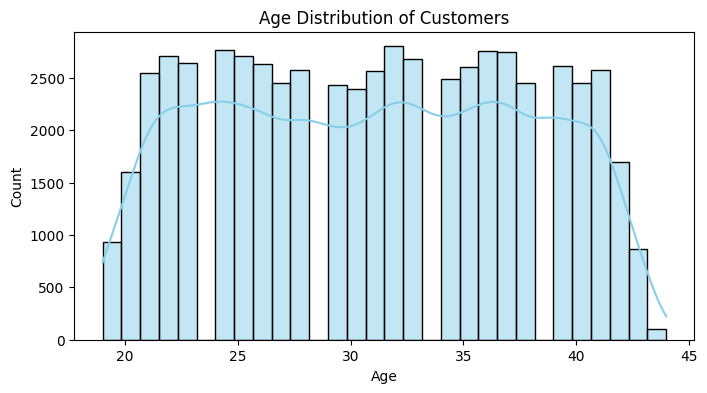

In [20]:
# Distribution of Age

plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

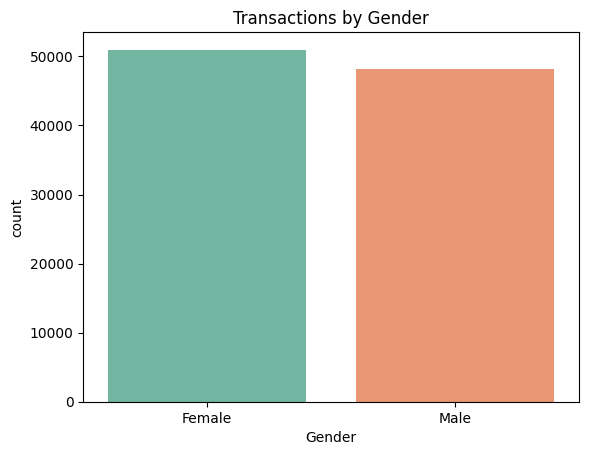

In [47]:

# Create a mapping dictionary
gender_mapping = {0: 'Female', 1: 'Male'} # Assuming 0 was Female and 1 was Male

# Apply the mapping to create a new column for visualization
df['Gender_Labelled'] = df['Gender'].map(gender_mapping)

# Now create the countplot with the labelled column
sns.countplot(x='Gender_Labelled', data=df, palette='Set2')
plt.title("Transactions by Gender")
plt.xlabel("Gender")
plt.ylabel("count")
plt.xticks(ticks=[0, 1], labels=['Female', 'Male']) # Explicitly set x-axis ticks and labels
plt.show()

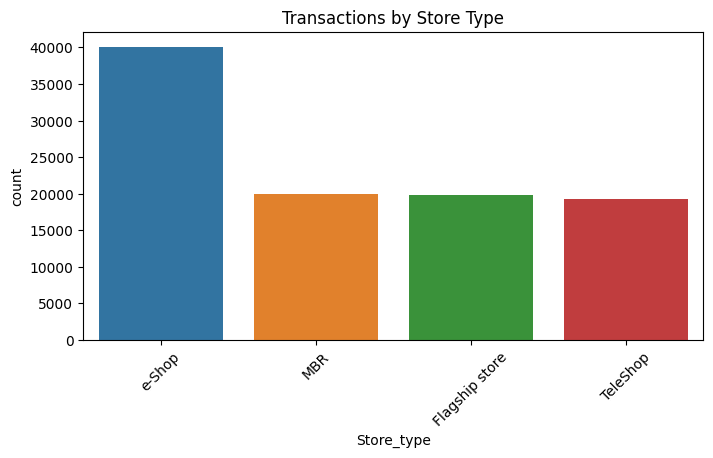

In [22]:
# Count by Store_type
plt.figure(figsize=(8, 4))
sns.countplot(x='Store_type', data=df, order=df['Store_type'].value_counts().index)
plt.title('Transactions by Store Type')
plt.xticks(rotation=45)
plt.show()

##  Multivariate Analysis

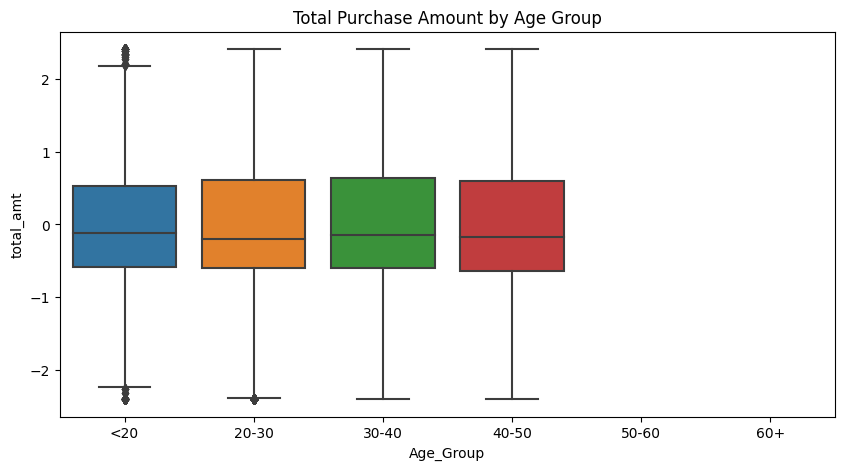

In [23]:
# Average Purchase Amount by Age Group

df['Age_Group'] = pd.cut(df['Age'], bins=[0, 20, 30, 40, 50, 60, 100],
                         labels=['<20', '20-30', '30-40', '40-50', '50-60', '60+'])

plt.figure(figsize=(10, 5))
sns.boxplot(x='Age_Group', y='total_amt', data=df)
plt.title('Total Purchase Amount by Age Group')
plt.show()

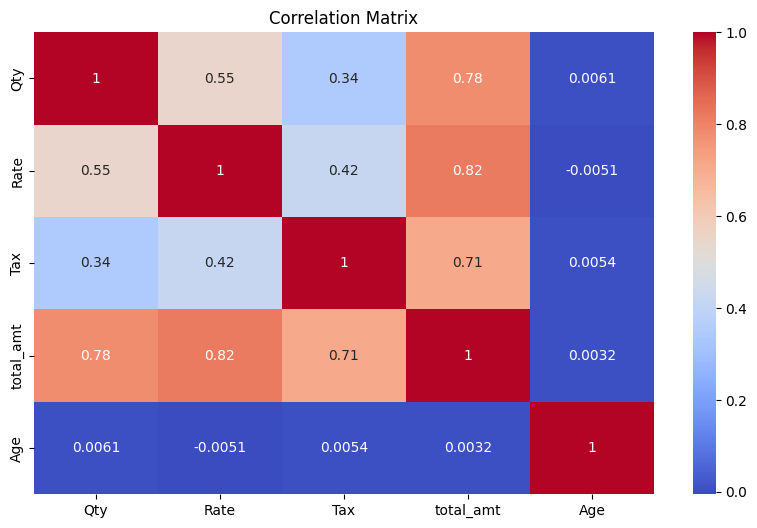

In [24]:
#  Heatmap of Correlation (Numerical)

plt.figure(figsize=(10, 6))
sns.heatmap(df[['Qty', 'Rate', 'Tax', 'total_amt', 'Age']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


## Time-Based Trends

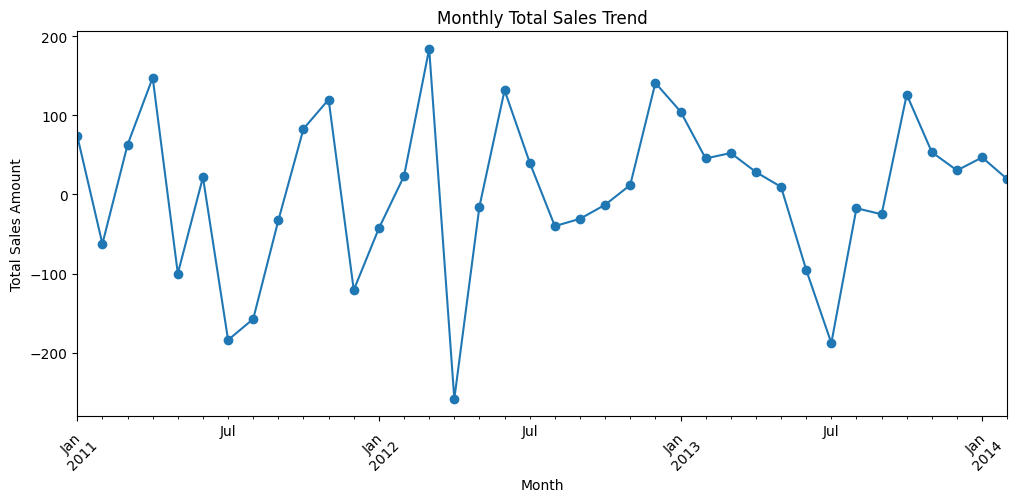

In [25]:
# Monthly Sales Trend

monthly_sales = df.groupby(df['tran_date'].dt.to_period('M'))['total_amt'].sum()
monthly_sales.plot(kind='line', figsize=(12, 5), marker='o')
plt.title('Monthly Total Sales Trend')
plt.ylabel('Total Sales Amount')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

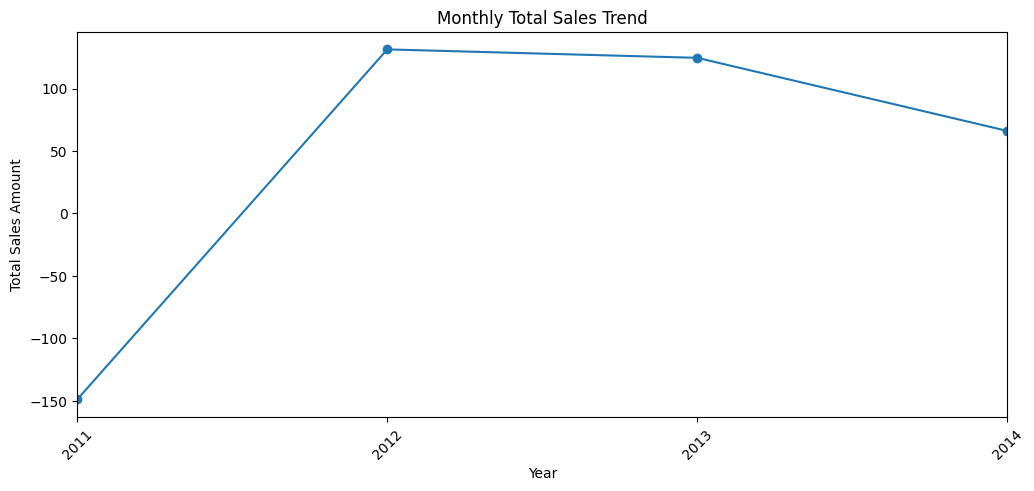

In [26]:
Annual_sales = df.groupby(df['tran_date'].dt.to_period('Y'))['total_amt'].sum()
Annual_sales.plot(kind='line', figsize=(12, 5), marker='o')
plt.title('Monthly Total Sales Trend')
plt.ylabel('Total Sales Amount')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.show()

## Product-Based Insights

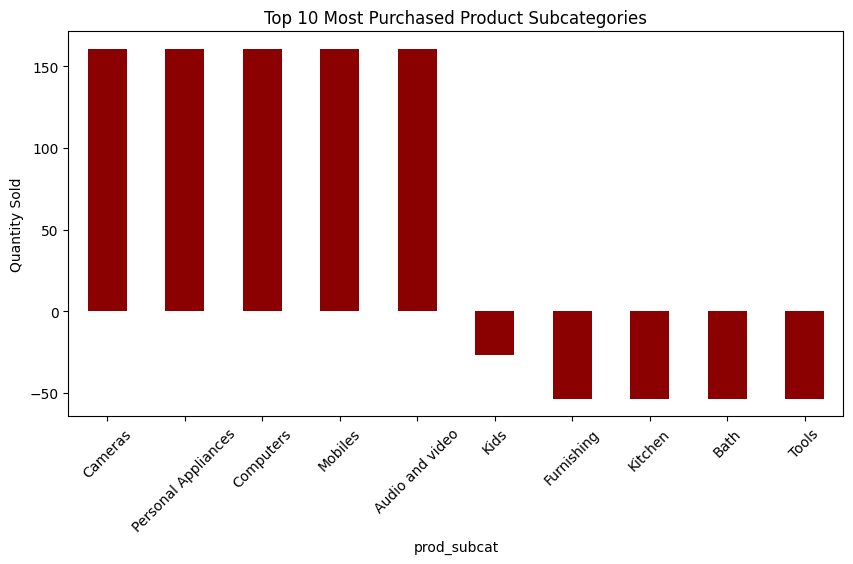

In [27]:
# Top 10 Most Purchased Product Subcategories

top_subcats = df.groupby('prod_subcat')['Qty'].sum().sort_values(ascending=False).head(10)
top_subcats.plot(kind='bar', color='darkred', figsize=(10, 5))
plt.title('Top 10 Most Purchased Product Subcategories')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.show()

###  Trend of total_amt Over Time

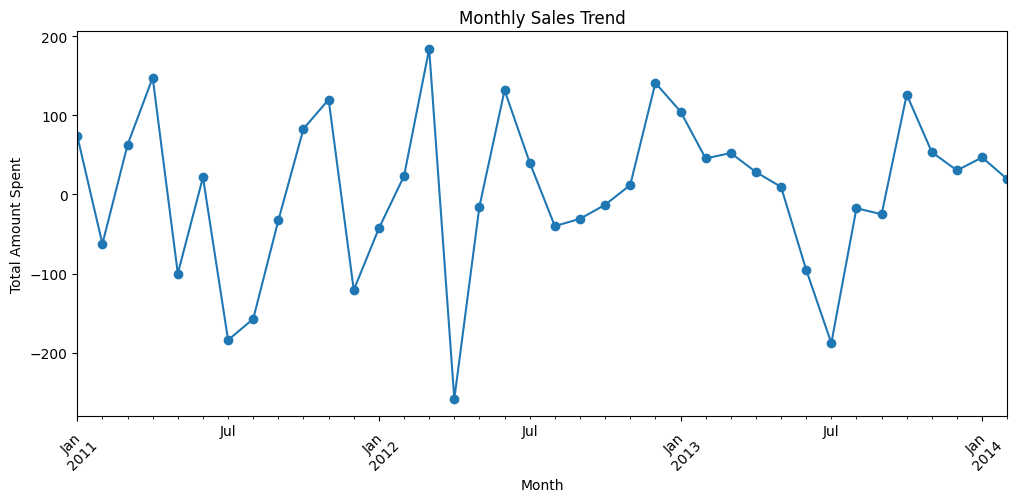

In [28]:
monthly_trend = df.groupby(df['tran_date'].dt.to_period('M'))['total_amt'].sum()
monthly_trend.plot(figsize=(12, 5), marker='o', title='Monthly Sales Trend')
plt.ylabel('Total Amount Spent')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

###  Seasonality Effects

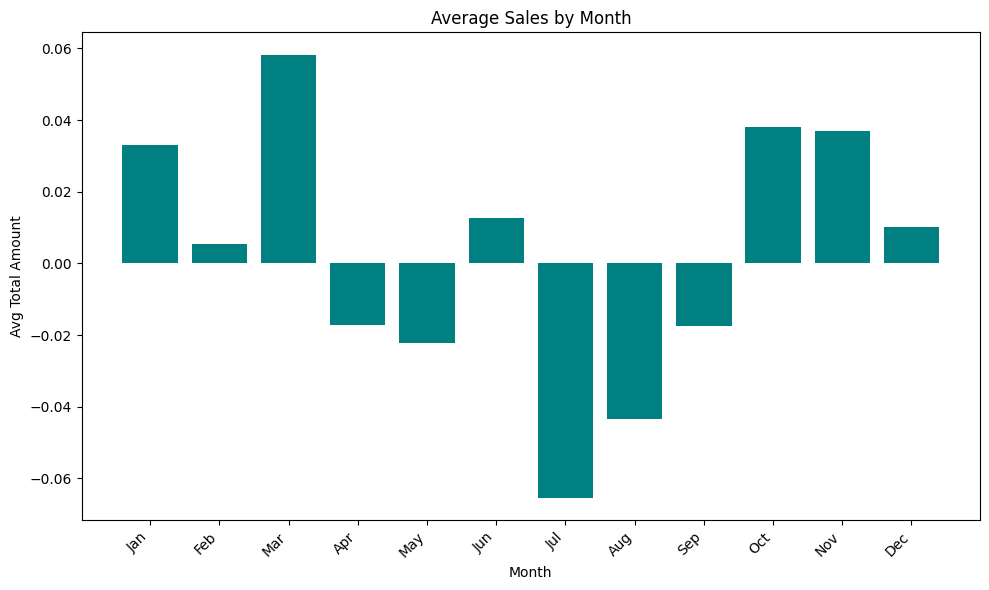

In [48]:
# Create a mapping from month numbers to names
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Map the numerical month values to month names for the x-axis labels
month_labels = seasonality.index.map(month_names)

# Create the bar plot
plt.figure(figsize=(10, 6)) # Adjust figure size if needed
plt.bar(month_labels, seasonality.values, color='teal')
plt.ylabel('Avg Total Amount')
plt.xlabel('Month')
plt.title('Average Sales by Month')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

### Store-Wise Sales Growth

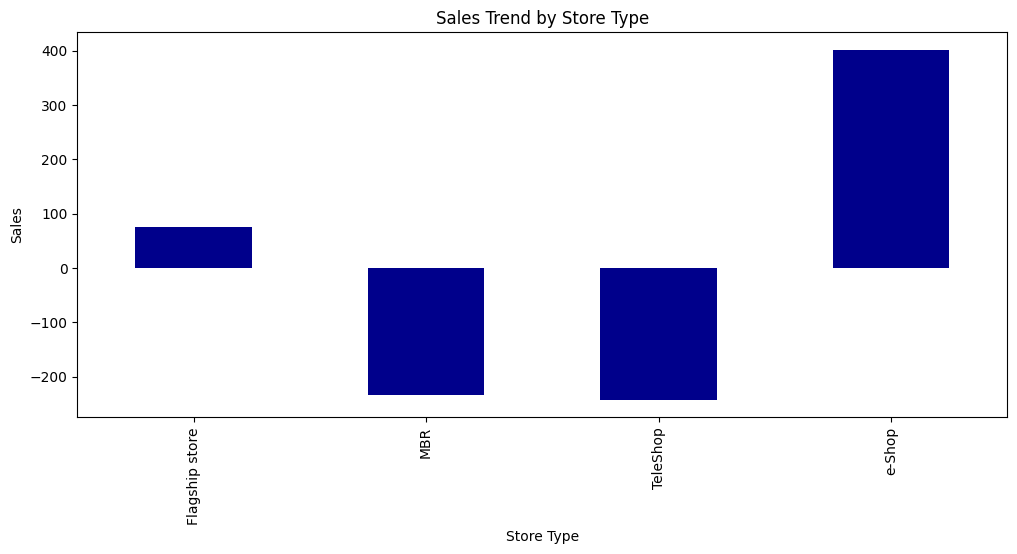

In [30]:
store_trend = df.groupby('Store_type')['total_amt'].sum()

# Plot the bar chart correctly
plt.figure(figsize=(12, 5))
store_trend.plot(kind='bar', color='darkblue', title='Sales Trend by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

## Relationships & Statistical Tests

### ANOVA: Does total_amt vary by Gender and Store_type?

In [31]:
from scipy.stats import f_oneway

anova_gender = f_oneway(
    df[df['Gender'] == 0]['total_amt'],
    df[df['Gender'] == 1]['total_amt']
)

anova_store = f_oneway(*[group['total_amt'].values for name, group in df.groupby('Store_type')])

print("ANOVA - Gender:", anova_gender)
print("ANOVA - Store Type:", anova_store)

ANOVA - Gender: F_onewayResult(statistic=0.8047790026080373, pvalue=0.3696705358594162)
ANOVA - Store Type: F_onewayResult(statistic=3.3709900616202946, pvalue=0.017633613382290744)


### Chi-Square Test: Gender vs Store_type

In [32]:
import pandas as pd
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['Gender'], df['Store_type'])
chi2_stat, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-Square Test Result:\nChi2 Stat: {chi2_stat:.2f}, p-value: {p:.4f}")

Chi-Square Test Result:
Chi2 Stat: 39.20, p-value: 0.0000


### Mutual Information (for categorical features vs total_amt)

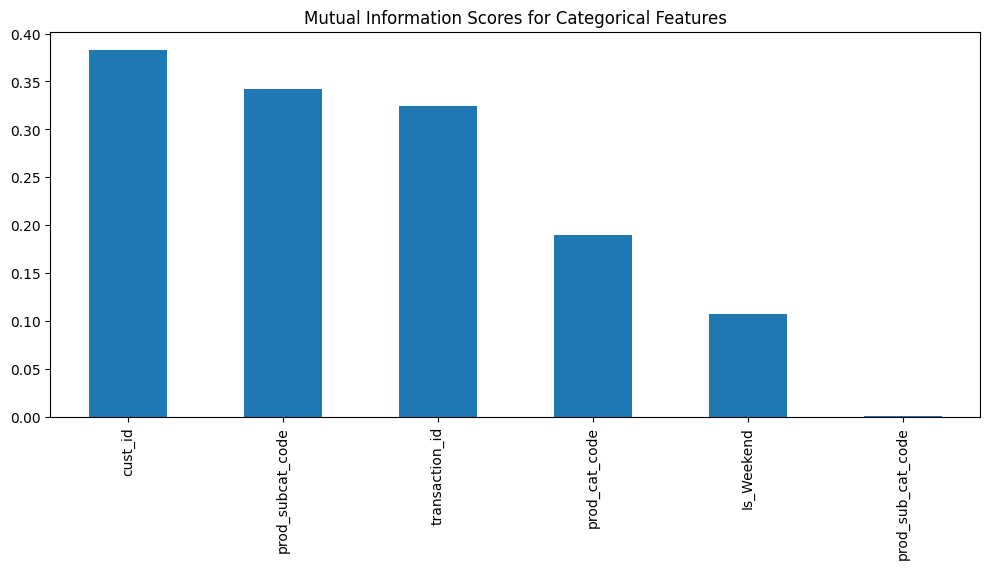

In [33]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_encoded and y are already defined

if 'Gender' in df_encoded.columns:
    df_encoded_without_gender = df_encoded.drop(columns=['Gender'])
    cat_features = df_encoded_without_gender.select_dtypes(include=['uint8', 'int64'])
else:
    cat_features = df_encoded.select_dtypes(include=['uint8', 'int64'])

mi_scores = mutual_info_regression(cat_features, y)
mi_series = pd.Series(mi_scores, index=cat_features.columns).sort_values(ascending=False)
mi_series.plot(kind='bar', figsize=(12, 5), title='Mutual Information Scores for Categorical Features')
plt.show()

###  Recursive Feature Elimination (with Linear Regression)

In [34]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Check data types of each column
print("Data Types Before Encoding:\n", X_train.dtypes)

# Convert categorical columns using Label Encoding
label_encoders = {}
for col in X_train.select_dtypes(include=['object']).columns:  
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])  # Convert categorical to numeric
    label_encoders[col] = le

# Convert categorical columns using One-Hot Encoding if necessary
X_train = pd.get_dummies(X_train, drop_first=True)

# Handle missing values
X_train.fillna(X_train.mean(), inplace=True)  

# Verify data types
print("Data Types After Encoding:\n", X_train.dtypes)

# Apply RFE for feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe.fit(X_train, y_train)

# Extract selected features
selected_features = X_train.columns[rfe.support_]
print("Top Features Selected by RFE:\n", selected_features.tolist())


Data Types Before Encoding:
 prod_cat_code                  int64
prod_sub_cat_code              int64
transaction_id                 int64
cust_id                        int64
prod_subcat_code               int64
Qty                          float64
Rate                         float64
Tax                          float64
Gender                         int64
city_code                    float64
Age                          float64
Month                        float64
Is_Weekend                     int64
Store_type_MBR                  bool
Store_type_TeleShop             bool
Store_type_e-Shop               bool
prod_cat_Books                  bool
prod_cat_Clothing               bool
prod_cat_Electronics            bool
prod_cat_Footwear               bool
prod_cat_Home and kitchen       bool
dtype: object
Data Types After Encoding:
 prod_cat_code                  int64
prod_sub_cat_code              int64
transaction_id                 int64
cust_id                        int64
prod

### City Code (proxy for region/tier) vs Revenue

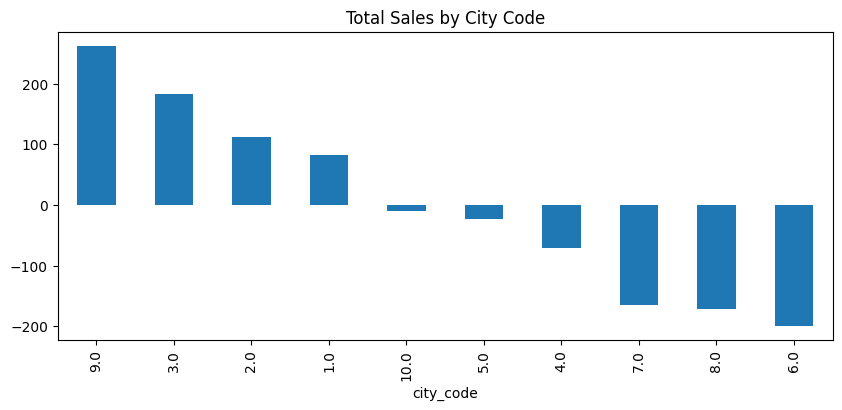

In [35]:
city_sales = df.groupby('city_code')['total_amt'].sum().sort_values(ascending=False)
city_sales.plot(kind='bar', figsize=(10, 4), title='Total Sales by City Code')
plt.show()

### Store Type & Customer Base:


In [36]:
customer_store = df.groupby('Store_type')['cust_id'].nunique()
revenue_store = df.groupby('Store_type')['total_amt'].sum()
volume_vs_revenue = pd.DataFrame({'Customers': customer_store, 'Revenue': revenue_store})
print(volume_vs_revenue.sort_values('Revenue', ascending=False))


                Customers     Revenue
Store_type                           
e-Shop               4366  401.671129
Flagship store       2941   75.282183
MBR                  3000 -234.520403
TeleShop             2912 -242.432908


### 5. Regression Analysis

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Simple Linear Regression with Qty
lr = LinearRegression()
lr.fit(X_train[['Qty']], y_train)
y_pred_lr = lr.predict(X_test[['Qty']])

print("Linear Regression R²:", r2_score(y_test, y_pred_lr))

Linear Regression R²: 0.5969638282772061


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
import pandas as pd  # Make sure you have pandas imported

# Assuming X_train, y_train, and X_test are pandas DataFrames

features = ['Qty', 'Rate', 'Tax', 'Age']

# Create an imputer object. Here, we'll use the mean strategy.
# You can choose 'median', 'most_frequent', or a constant value as well.
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and then transform both training and testing data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

# Initialize and train the multiple linear regression model on the imputed training data
lr_multi = LinearRegression()
lr_multi.fit(X_train_imputed, y_train)

# Make predictions using the imputed testing data
y_pred_multi = lr_multi.predict(X_test_imputed)

# Evaluate the model
r2 = r2_score(y_test, y_pred_multi)
print(f"Multiple Linear Regression R^2 (after imputation): {r2}")

Multiple Linear Regression R^2 (after imputation): 0.942037873283317


### T-Test (Spending by Gender)

In [39]:
from scipy.stats import ttest_ind

male_spend = df[df['Gender'] == 1]['total_amt']
female_spend = df[df['Gender'] == 0]['total_amt']

t_stat, p_val = ttest_ind(male_spend, female_spend)
print("T-Test: t-stat =", t_stat, ", p-value =", p_val)

T-Test: t-stat = 0.8970947567609775 , p-value = 0.3696705358740231


### A/B Test (Revenue by Store Type)

In [40]:
store_types = df['Store_type'].unique()

# Example: Compare two types
group_A = df[df['Store_type'] == store_types[0]]['total_amt']
group_B = df[df['Store_type'] == store_types[1]]['total_amt']

t_stat_ab, p_val_ab = ttest_ind(group_A, group_B)
print("A/B Test between Store Types:", store_types[0], "vs", store_types[1])
print("t-stat:", t_stat_ab, ", p-value:", p_val_ab)

A/B Test between Store Types: e-Shop vs MBR
t-stat: 2.503982291340263 , p-value: 0.012283047919213879


### Polynomial Regression (Spending vs Age)

In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd

# Assuming X_train, y_train, and X_test are pandas DataFrames

# Create an imputer object (using 'mean' strategy as an example)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the training data
X_train_age_imputed = pd.DataFrame(imputer.fit_transform(X_train[['Age']]), columns=['Age'])

# Transform the testing data
X_test_age_imputed = pd.DataFrame(imputer.transform(X_test[['Age']]), columns=['Age'])

# Create the polynomial regression pipeline with imputed data
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model.fit(X_train_age_imputed, y_train)
y_poly_pred = poly_model.predict(X_test_age_imputed)

print("Polynomial Regression R² (after imputation):", r2_score(y_test, y_poly_pred))

Polynomial Regression R² (after imputation): -0.00022250882258445515


### Ridge & Lasso Regression

In [42]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming X_train, y_train, X_test, and features are already defined

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or choose another appropriate strategy

# Fit and transform the training data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)

# Transform the testing data
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

# Ridge Regression with imputed data
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_imputed, y_train)
print("Ridge R² (after imputation):", ridge.score(X_test_imputed, y_test))

# Lasso Regression with imputed data
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_imputed, y_train)
print("Lasso R² (after imputation):", lasso.score(X_test_imputed, y_test))

Ridge R² (after imputation): 0.9420378969075587
Lasso R² (after imputation): 0.9419316190152968


### Decision Tree Regression

In [55]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming X_train, y_train, X_test are pandas DataFrames
# Assuming 'features' is defined as the list of feature columns

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or choose your preferred strategy

# Fit and transform the training data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)

# Transform the testing data
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

# Initialize and train the Decision Tree Regressor on the imputed training data
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train_imputed, y_train)

# Evaluate the model on the imputed testing data
print("Decision Tree R² (after imputation):", tree.score(X_test_imputed, y_test))

Decision Tree R² (after imputation): 1.0


### Random Forest Regression

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming X_train, y_train, X_test are pandas DataFrames
# Assuming 'features' is defined as the list of feature columns

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or choose your preferred strategy

# Fit and transform the training data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)

# Transform the testing data
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

# Initialize and train the Random Forest Regressor on the imputed training data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_imputed, y_train)

# Evaluate the model on the imputed testing data
print("Random Forest R² (after imputation):", rf.score(X_test_imputed, y_test))

Random Forest R² (after imputation): 1.0


### Evaluation Metrics Summary

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")

# Assuming X_train, y_train, X_test, and features are defined

# Create and fit the imputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

# Initialize and train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_imputed, y_train)

# Evaluate the model using the imputed test data
evaluate_model(rf, X_test_imputed, y_test)

R² Score: 1.0000
Mean Squared Error: 0.0000


### Classification: Predict High Spenders

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Create Target Variable
# Define high spender: spending above 75th percentile
threshold = df['total_amt'].quantile(0.75)
df['high_spender'] = (df['total_amt'] > threshold).astype(int)  # Create 'high_spender' column in df

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['Store_type'], drop_first=True)  # Encoding 'Store_type'

# Define feature set
features = ['Qty', 'Rate', 'Tax', 'Age', 'Gender'] + list(df_encoded.columns[df_encoded.columns.str.startswith('Store_type_')])

# Prepare X and y
X = df_encoded[features]  # Ensure 'features' are correctly referenced
y = df_encoded['high_spender']  # Now using df_encoded where 'high_spender' exists

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print("Data successfully prepared!")  # Confirmation message

Data successfully prepared!


### We'll apply each and evaluate using standard classification metrics.



In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming X_train, y_train, X_test are pandas DataFrames

# Identify your feature columns (assuming 'features' list is still relevant or define them)
# For example, if all columns in X_train are features:
features = X_train.columns

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or choose an appropriate strategy

# Fit and transform the training data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)

# Transform the testing data
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

models = {
    "Logistic": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_test_imputed)
    print(f"\n🔍 {name} Classification Report:\n")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    if hasattr(model, "predict_proba"):
        print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test_imputed)[:, 1]))
    else:
        print("ROC AUC: Not available for this model") # e.g., SVC without probability=True


Training Logistic...

🔍 Logistic Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14870
           1       1.00      0.99      0.99      4956

    accuracy                           1.00     19826
   macro avg       1.00      1.00      1.00     19826
weighted avg       1.00      1.00      1.00     19826

Confusion Matrix:
 [[14847    23]
 [   34  4922]]
ROC AUC: 0.9999762672784797

Training KNN...

🔍 KNN Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14870
           1       0.99      0.99      0.99      4956

    accuracy                           1.00     19826
   macro avg       1.00      1.00      1.00     19826
weighted avg       1.00      1.00      1.00     19826

Confusion Matrix:
 [[14840    30]
 [   35  4921]]
ROC AUC: 0.9999531858837934

Training SVM...

🔍 SVM Classification Report:

              precision    recall  f


Training Logistic...


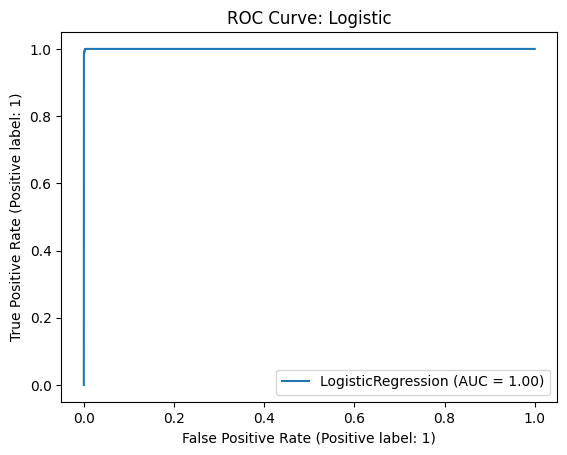


Training KNN...


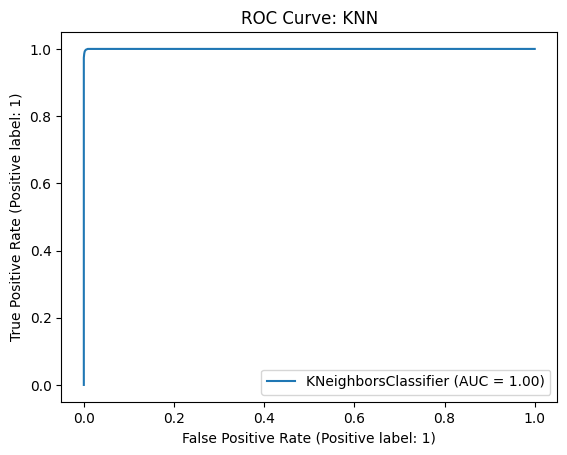


Training SVM...


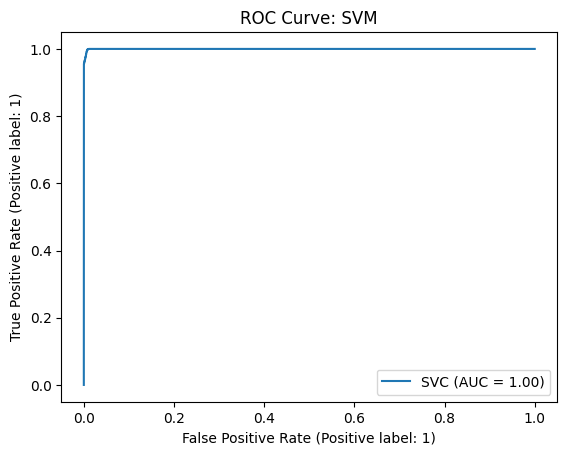


Training NaiveBayes...


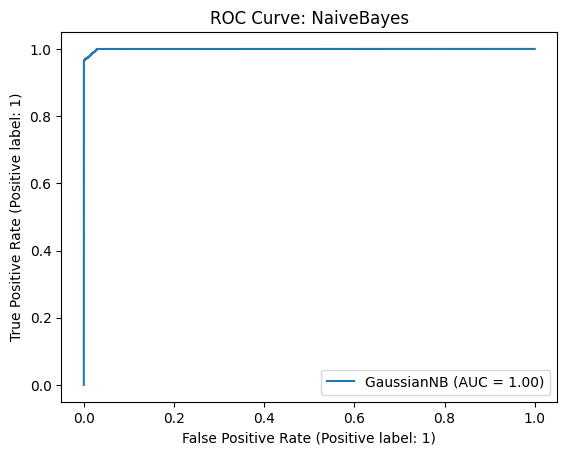


Training DecisionTree...


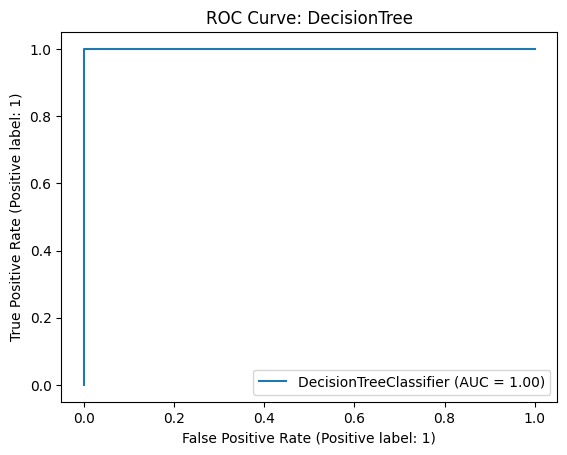


Training RandomForest...


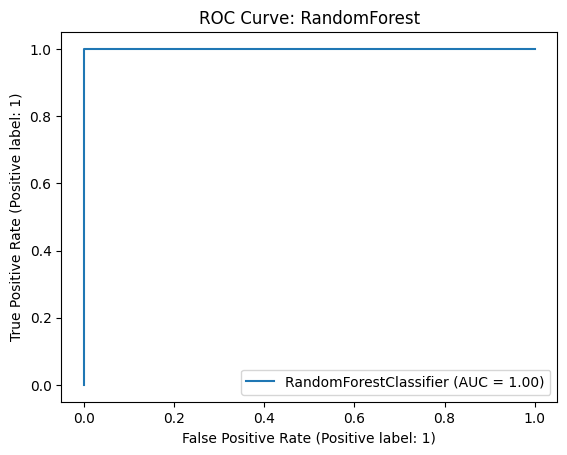

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_train, y_train, X_test are pandas DataFrames
# Assuming 'features' is defined as the list of feature columns

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or your preferred strategy

# Fit the imputer on the training data and transform both training and testing data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

models = {
    "Logistic": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_imputed, y_train)  # Train on imputed training data

    if not hasattr(model, "predict_proba"):
        print(f"{name} does not support probability predictions, skipping ROC curve...")
        continue

    if not hasattr(model, "classes_"):
        print(f"{name} is not fitted yet, skipping ROC curve...")
        continue

    RocCurveDisplay.from_estimator(model, X_test_imputed, y_test)  # Use imputed testing data
    plt.title(f"ROC Curve: {name}")
    plt.show()

In [71]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Unique classes in y_test:", set(y_test))

X_test shape: (19826, 8)
y_test shape: (19826,)
Unique classes in y_test: {0, 1}


 ### Clustering (Unsupervised Customer Segmentation)

In [83]:
# Select Features
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_cluster = df[['Qty', 'Rate', 'Tax', 'Age']]


No NaN values found after imputation.


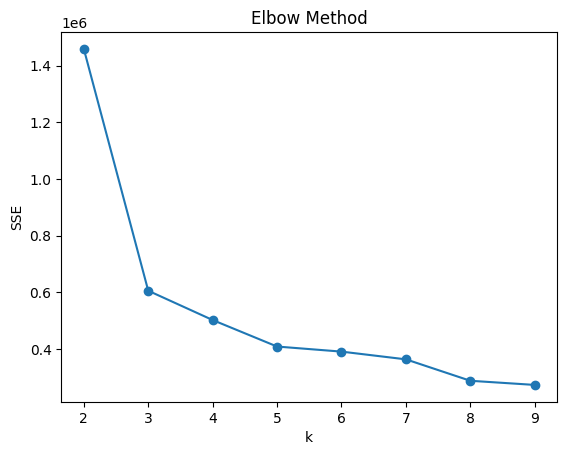

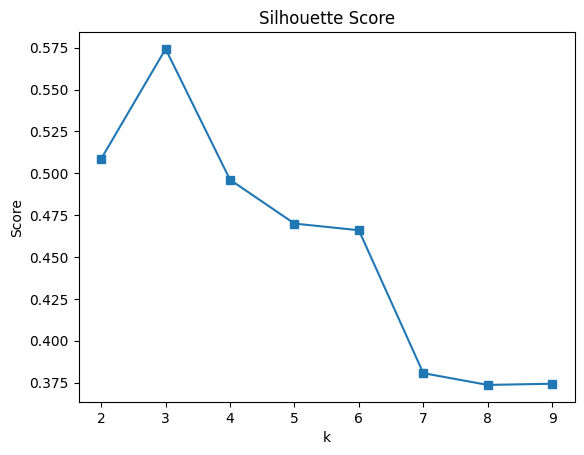

In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pandas as pd  # Make sure pandas is imported if X_cluster is a DataFrame
import numpy as np   # It's good practice to import numpy as well

# Assuming X_cluster is your feature data for clustering

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or choose your preferred strategy

# Fit and transform your clustering data
X_cluster_imputed = imputer.fit_transform(X_cluster)

# Check for remaining NaN values
if np.isnan(X_cluster_imputed).any():
    print("Warning: NaN values still present after imputation!")
    # You might want to inspect these rows to understand why
    # print(pd.DataFrame(X_cluster_imputed)[np.isnan(X_cluster_imputed).any(axis=1)])
else:
    print("No NaN values found after imputation.")

sse = []
sil = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto') # Added n_init for future compatibility
    km.fit(X_cluster_imputed)
    sse.append(km.inertia_)
    sil.append(silhouette_score(X_cluster_imputed, km.labels_))

plt.plot(range(2, 10), sse, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

plt.plot(range(2, 10), sil, marker='s')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")
plt.show()

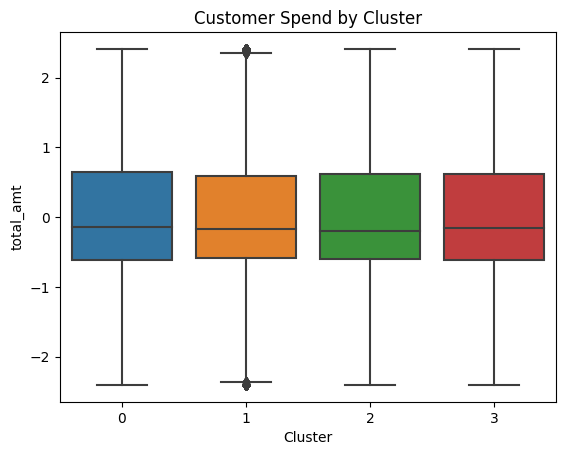

In [75]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Assuming your data is in a pandas DataFrame

# Assuming df is your DataFrame and X_cluster was your original feature matrix
# Make sure X_cluster_imputed is the result of your imputation step

# Final Clustering - Use the imputed data
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto') # Added n_init for future compatibility
df['Cluster'] = kmeans.fit_predict(X_cluster_imputed)

# Analyze clusters
sns.boxplot(x='Cluster', y='total_amt', data=df)
plt.title("Customer Spend by Cluster")
plt.show()

### Predictive Analysis: Use Best Model to Predict Future Outcomes

### Prescriptive Analysis: What if Senarios